In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install xgboost
!pip install tensorflow

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# World Development Indicators dataset (GDP + Poverty indicators)
wdi = pd.read_csv('/content/drive/MyDrive/GDP-LSTM-Project/WDICSV.csv')

# CO2 emissions dataset
co2 = pd.read_csv('/content/drive/MyDrive/GDP-LSTM-Project/co2_data.csv')

# Poverty dataset (World Bank API dataset)
poverty = pd.read_csv(
    '/content/drive/MyDrive/GDP-LSTM-Project/API_11_DS2_en_csv_v2_12681.csv',
    skiprows=4
)

In [ ]:
wdi.head()
co2.head()
poverty.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,Unnamed: 69
0,Aruba,ABW,Annualized average growth rate in per capita r...,SI.SPR.PCAP.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Aruba,ABW,"Survey mean consumption or income per capita, ...",SI.SPR.PCAP,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Aruba,ABW,Annualized average growth rate in per capita r...,SI.SPR.PC40.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Aruba,ABW,"Survey mean consumption or income per capita, ...",SI.SPR.PC40,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Aruba,ABW,Poverty gap at $8.30 a day (2021 PPP) (%),SI.POV.UMIC.GP,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
wdi.columns
co2.columns
poverty.columns

Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022',
       '2023', '2024', 'Unnamed: 69'],
      dtype='object')

In [ ]:
wdi.columns

Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022',
       '2023', '2024'],
      dtype='object')

In [ ]:
gdp = wdi[wdi['Indicator Name'] == 'GDP (current US$)']

In [ ]:
gdp = gdp.melt(
    id_vars=['Country Name','Country Code','Indicator Name','Indicator Code'],
    var_name='Year',
    value_name='GDP'
)

In [ ]:
gdp.head()

,Country Name,Country Code,Indicator Name,Indicator Code,Year,GDP
0,Africa Eastern and Southern,AFE,GDP (current US$),NY.GDP.MKTP.CD,1960,2.420569e+10
1,Africa Western and Central,AFW,GDP (current US$),NY.GDP.MKTP.CD,1960,1.190481e+10
2,Arab World,ARB,GDP (current US$),NY.GDP.MKTP.CD,1960,NaN
3,Caribbean small states,CSS,GDP (current US$),NY.GDP.MKTP.CD,1960,1.165303e+09
4,Central Europe and the Baltics,CEB,GDP (current US$),NY.GDP.MKTP.CD,1960,NaN


In [ ]:
gdp = gdp[gdp['Year'].str.isnumeric()]
gdp['Year'] = gdp['Year'].astype(int)

In [ ]:
gdp = gdp[['Country Name','Country Code','Year','GDP']]

In [ ]:
co2.columns

Index(['FREQ', 'FREQ_LABEL', 'REF_AREA', 'REF_AREA_LABEL', 'INDICATOR',
       'INDICATOR_LABEL', 'UNIT_MEASURE', 'UNIT_MEASURE_LABEL', 'DATABASE_ID',
       'DATABASE_ID_LABEL',
       ...
       '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022',
       '2023'],
      dtype='object', length=290)

In [ ]:
co2['INDICATOR_LABEL'].unique()

array(['Annual CO2 emissions from cement - Annual emissions of carbon dioxide (CO2) from cement, measured in million tonnes.',
       'Annual CO2 emissions from cement (per capita) - Annual emissions of carbon dioxide (CO2) from cement, measured in tonnes per person.',
       'Annual CO2 emissions - Annual total emissions of carbon dioxide (CO2), excluding land-use change, measured in million tonnes.',
       'Annual CO2 emissions growth (abs) - Annual growth in total emissions of carbon dioxide (CO2), excluding land-use change, measured in million tonnes.',
       'Annual CO2 emissions growth (%) - Annual percentage growth in total emissions of carbon dioxide (CO2), excluding land-use change.',
       'Annual CO2 emissions (per capita) - Annual total emissions of carbon dioxide (CO2), excluding land-use change, measured in tonnes per person.',
       'Annual CO2 emissions per unit energy (kg per kilowatt-hour) - Annual total emissions of carbon dioxide (CO2), excluding land-use change

In [ ]:
selected_indicators = [
    'Annual CO2 emissions - Annual total emissions of carbon dioxide (CO2), excluding land-use change, measured in million tonnes.',
    'Annual CO2 emissions (per capita) - Annual total emissions of carbon dioxide (CO2), excluding land-use change, measured in tonnes per person.',
    'Annual CO2 emissions per GDP (kg per international-$) - Annual total emissions of carbon dioxide (CO2), excluding land-use change, measured in kilograms per dollar of GDP (2011 international-$).',
    'Primary energy consumption - Measured in terawatt-hours.',
    'Population - Population by country, available from 10,000 BCE to 2100, based on data and estimates from different sources.'
]

co2_filtered = co2[co2['INDICATOR_LABEL'].isin(selected_indicators)].copy()

In [ ]:
co2_long = co2_filtered.melt(
    id_vars=['REF_AREA_LABEL', 'INDICATOR_LABEL'],
    var_name='Year',
    value_name='Value'
)

In [ ]:
co2_long = co2_long[co2_long['Year'].str.isnumeric()]
co2_long['Year'] = co2_long['Year'].astype(int)

co2_long.rename(columns={
    'REF_AREA_LABEL': 'Country Name'
}, inplace=True)

In [ ]:
co2_final = co2_long.pivot_table(
    index=['Country Name', 'Year'],
    columns='INDICATOR_LABEL',
    values='Value'
).reset_index()

In [ ]:
co2_final.rename(columns={
    selected_indicators[0]: 'CO2_total',
    selected_indicators[1]: 'CO2_per_capita',
    selected_indicators[2]: 'CO2_per_GDP',
    selected_indicators[3]: 'Energy_consumption',
    selected_indicators[4]: 'Population'
}, inplace=True)

In [ ]:
co2_final.head()
co2_final.shape

(37893, 7)

In [ ]:
poverty = poverty[poverty['Indicator Name'].str.contains('poverty', case=False, na=False)]

In [ ]:
poverty_years = [col for col in poverty.columns if col.isdigit()]

In [ ]:
poverty_long = poverty.melt(
    id_vars=['Country Name', 'Country Code', 'Indicator Name'],
    value_vars=poverty_years,
    var_name='Year',
    value_name='Poverty'
)

In [ ]:
poverty_long['Year'] = poverty_long['Year'].astype(int)

In [ ]:
poverty_long.head()
poverty_long.shape

(121030, 5)

In [ ]:
poverty_long = poverty_long[['Country Name','Year','Poverty']]

In [ ]:
poverty_long = poverty_long.dropna()

In [ ]:
poverty_long.shape

(19183, 3)

In [ ]:
df = gdp.merge(co2_final, on=['Country Name','Year'], how='inner')

df = df.merge(
    poverty_long[['Country Name','Year','Poverty']],
    on=['Country Name','Year'],
    how='inner'
)

In [ ]:
print(df.shape)
print(df.columns)
df.head()

(15935, 10)
Index(['Country Name', 'Country Code', 'Year', 'GDP', 'CO2_per_capita',
       'CO2_total', 'CO2_per_GDP', 'Population', 'Energy_consumption',
       'Poverty'],
      dtype='object')


,Country Name,Country Code,Year,GDP,CO2_per_capita,CO2_total,CO2_per_GDP,Population,Energy_consumption,Poverty
0,United States,USA,1963,6.370586e+11,16.47,3126.488,0.847,189825228.0,NaN,2.4
1,United States,USA,1963,6.370586e+11,16.47,3126.488,0.847,189825228.0,NaN,5.2
2,United States,USA,1963,6.370586e+11,16.47,3126.488,0.847,189825228.0,NaN,1.2
3,United States,USA,1963,6.370586e+11,16.47,3126.488,0.847,189825228.0,NaN,2.2
4,United States,USA,1963,6.370586e+11,16.47,3126.488,0.847,189825228.0,NaN,1.0


In [ ]:
# Check missing values
df.isnull().sum()

,0
Country Name,0
Country Code,0
Year,0
GDP,73
CO2_per_capita,8
CO2_total,8
CO2_per_GDP,997
Population,0
Energy_consumption,402
Poverty,0


In [ ]:
df = df.dropna()

In [ ]:
# Target variables
y = df[['GDP', 'CO2_per_capita', 'Poverty']]

# Features (use all remaining useful numeric columns)
X = df.drop(columns=['GDP', 'CO2_per_capita', 'Poverty',
                     'Country Name', 'Country Code'])

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,   # 80% training, 20% testing
    random_state=42
)

In [ ]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(11014, 16) (2754, 16)
(11014, 3) (2754, 3)


In [ ]:
#MULTIPLE LINEAR REGRESSION
X = df.drop(columns=['GDP','CO2_per_capita','Poverty','Country Name','Country Code'])
y = df[['GDP','CO2_per_capita','Poverty']]

In [ ]:
import numpy as np

# Replace infinity with NaN
X = X.replace([np.inf, -np.inf], np.nan)

# Remove rows with NaN
X = X.dropna()
y = y.loc[X.index]

/tmp/ipython-input-1735048054.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = X.replace([np.inf, -np.inf], np.nan)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor

lr_model = MultiOutputRegressor(LinearRegression())
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)

In [ ]:
from sklearn.metrics import r2_score

r2_lr = r2_score(y_test, y_pred_lr)

print("R2 score for Linear Regression:", r2_lr)

R2 score for Linear Regression: 0.5094533633621713


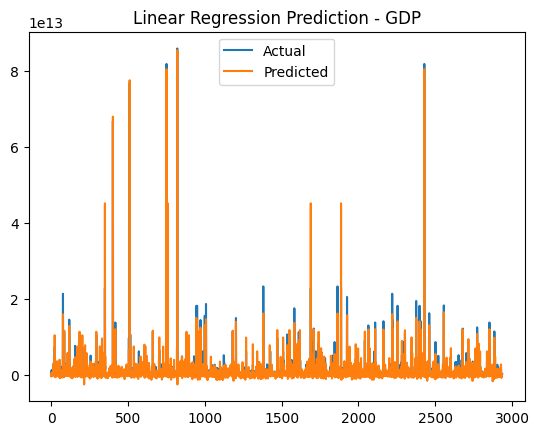

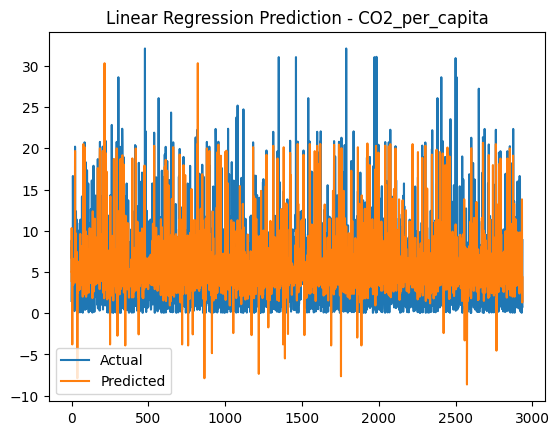

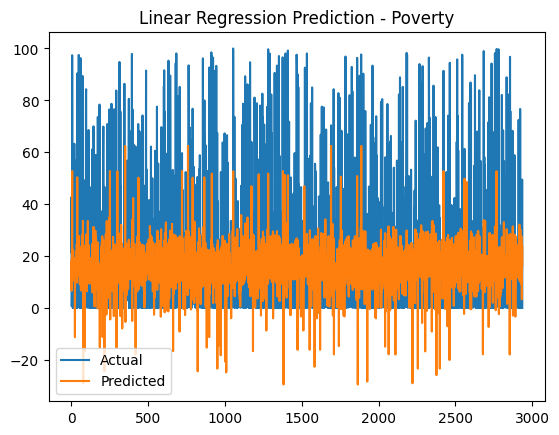

In [ ]:
targets = ['GDP', 'CO2_per_capita', 'Poverty']

for i, target in enumerate(targets):
    plt.figure()
    plt.plot(y_test.iloc[:, i].values, label="Actual")
    plt.plot(y_pred_lr[:, i], label="Predicted")
    plt.title("Linear Regression Prediction - " + target)
    plt.legend()
    plt.show()

In [ ]:
#SVM
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

In [ ]:
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

svm_model = MultiOutputRegressor(
    SVR(kernel='rbf', C=100, gamma=0.01, epsilon=0.001)
)

svm_model.fit(X_train_scaled, y_train_scaled)

MultiOutputRegressor(estimator=SVR(C=100, epsilon=0.001, gamma=0.01))

In [ ]:
y_pred_svm_scaled = svm_model.predict(X_test_scaled)

y_pred_svm = scaler_y.inverse_transform(y_pred_svm_scaled)

In [ ]:
from sklearn.metrics import r2_score

r2_svm = r2_score(y_test, y_pred_svm)
print("Improved SVM R²:", r2_svm)

Improved SVM R²: 0.613492359015586


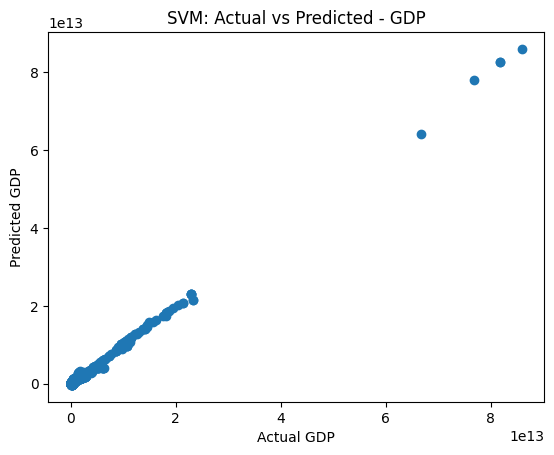

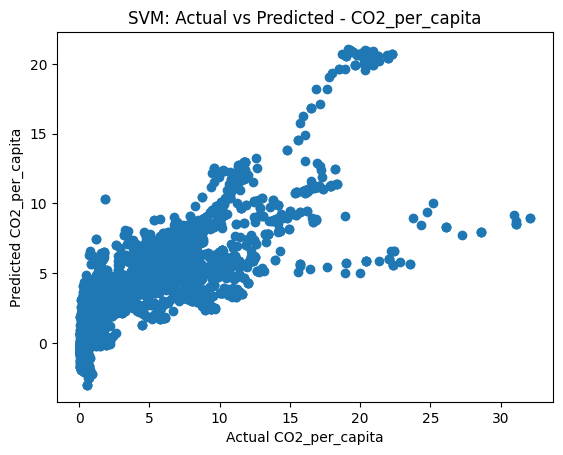

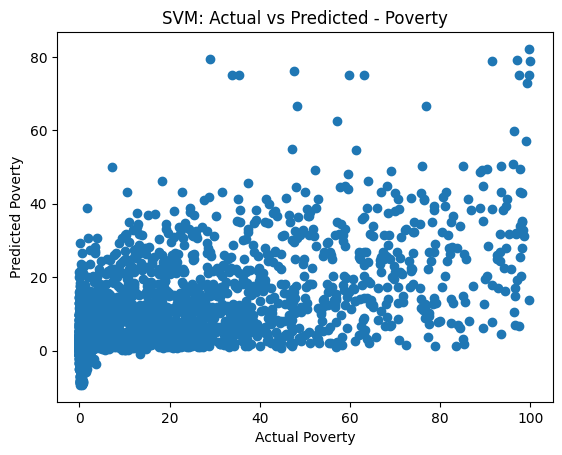

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

targets = ['GDP', 'CO2_per_capita', 'Poverty']

y_test_np = np.array(y_test)
y_pred_svm_np = np.array(y_pred_svm)

for i in range(len(targets)):
    plt.figure()
    plt.scatter(y_test_np[:, i], y_pred_svm_np[:, i])
    plt.xlabel("Actual " + targets[i])
    plt.ylabel("Predicted " + targets[i])
    plt.title("SVM: Actual vs Predicted - " + targets[i])
    plt.show()

In [ ]:
#RANDOM FOREST REGRESSION
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=300, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

In [ ]:
y_pred_rf = rf_model.predict(X_test)

r2_rf = r2_score(y_test, y_pred_rf)
print("Random Forest R2 Score:", r2_rf)

Random Forest R2 Score: 0.8436695094102333


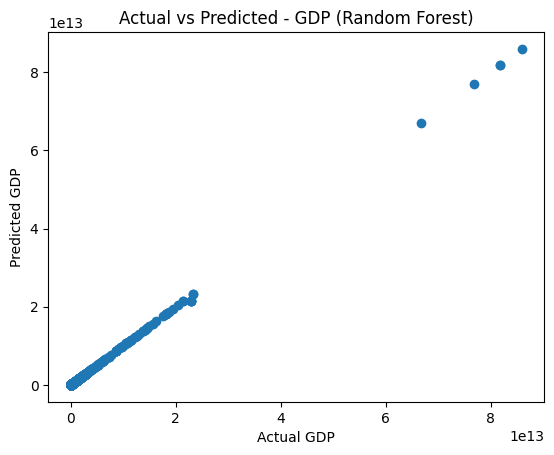

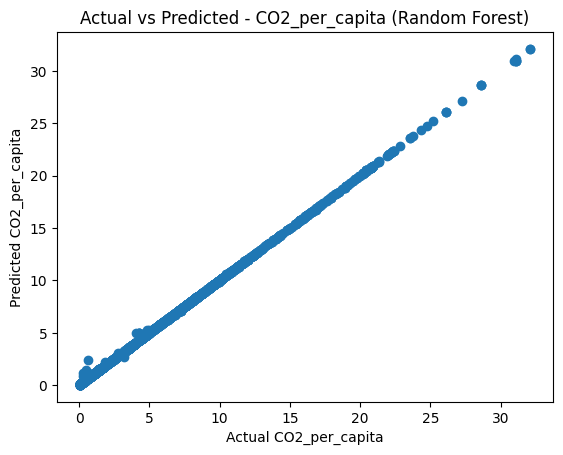

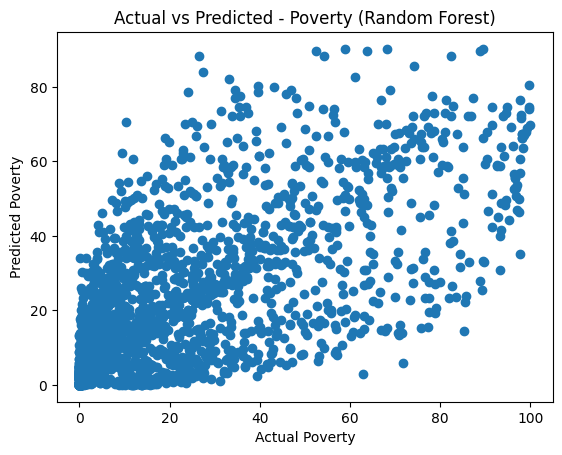

In [ ]:
import matplotlib.pyplot as plt

targets = ['GDP', 'CO2_per_capita', 'Poverty']

for i, target in enumerate(targets):
    plt.figure()
    plt.scatter(y_test.iloc[:, i], y_pred_rf[:, i])
    plt.xlabel("Actual " + target)
    plt.ylabel("Predicted " + target)
    plt.title("Actual vs Predicted - " + target + " (Random Forest)")
    plt.show()

In [ ]:
#LSTM
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [ ]:
import numpy as np
import pandas as pd

# Convert to numeric
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

y_train = y_train.apply(pd.to_numeric, errors='coerce')
y_test = y_test.apply(pd.to_numeric, errors='coerce')

# Replace infinity
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_test = X_test.replace([np.inf, -np.inf], np.nan)

# Fill missing values
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

y_train = y_train.fillna(0)
y_test = y_test.fillna(0)

In [ ]:
X_train_np = X_train.values.astype(np.float32)
X_test_np = X_test.values.astype(np.float32)

y_train_np = y_train.values.astype(np.float32)
y_test_np = y_test.values.astype(np.float32)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train_np)
X_test_scaled = scaler_X.transform(X_test_np)

y_train_scaled = scaler_y.fit_transform(y_train_np)
y_test_scaled = scaler_y.transform(y_test_np)

In [ ]:
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model_lstm = Sequential()

model_lstm.add(LSTM(128, return_sequences=True, input_shape=(1, X_train_scaled.shape[1])))
model_lstm.add(Dropout(0.2))

model_lstm.add(LSTM(64))
model_lstm.add(Dropout(0.2))

model_lstm.add(Dense(32, activation='relu'))
model_lstm.add(Dense(3))

model_lstm.compile(
    optimizer='adam',
    loss='mse'
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
history = model_lstm.fit(
    X_train_lstm,
    y_train_scaled,
    epochs=80,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/80
294/294 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0103 - val_loss: 0.0102
Epoch 2/80
294/294 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0099 - val_loss: 0.0112
Epoch 3/80
294/294 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0103 - val_loss: 0.0115
Epoch 4/80
294/294 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0108 - val_loss: 0.0102
Epoch 5/80
294/294 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0098 - val_loss: 0.0121
Epoch 6/80
294/294 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0100 - val_loss: 0.0099
Epoch 7/80
294/294 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0100 - val_loss: 0.0106
Epoch 8/80
294/294 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0099 - val_loss: 0.0100
Epoch 9/80
294/294 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0100 - val_loss: 0.0100
Epoch 10/80
294/294 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0101 - val_loss: 0.0102
Epoch 11/80
294/294 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0101 - val_loss: 0.0100
Epoch 12/80
294/294 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/ste

In [ ]:
y_pred_scaled = model_lstm.predict(X_test_lstm)

y_pred_lstm = scaler_y.inverse_transform(y_pred_scaled)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [ ]:
from sklearn.metrics import r2_score

r2_lstm = r2_score(y_test_np, y_pred_lstm)
print("Improved LSTM R²:", r2_lstm)

Improved LSTM R²: 0.8173416256904602


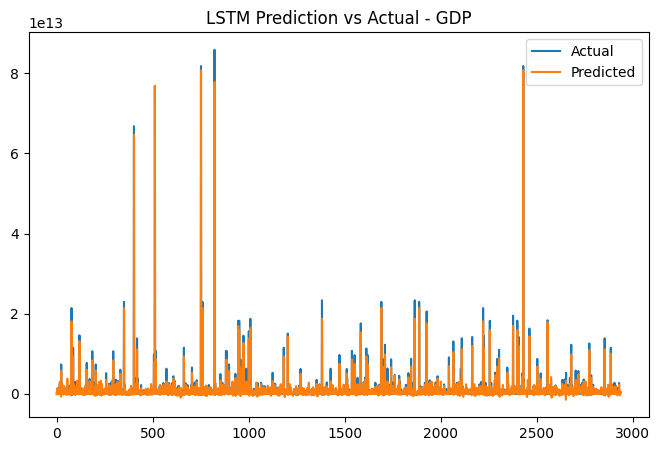

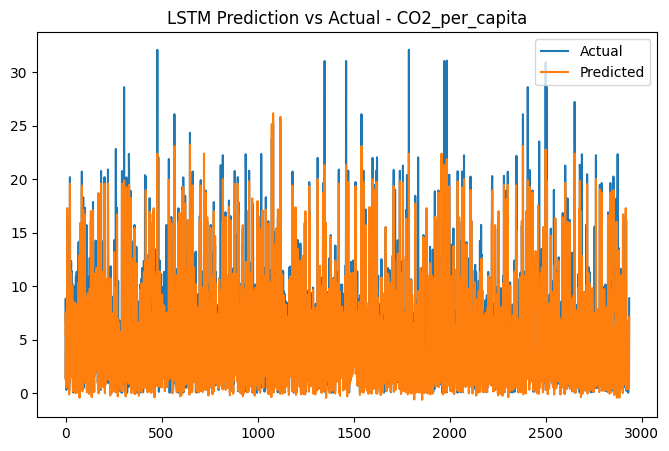

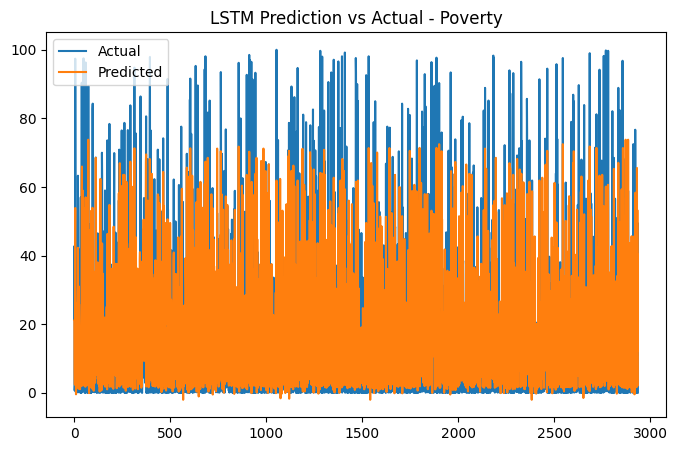

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Convert y_test to numpy if it is a dataframe
y_test_np = y_test.values if hasattr(y_test, "values") else y_test

targets = ['GDP', 'CO2_per_capita', 'Poverty']

for i in range(len(targets)):
    plt.figure(figsize=(8,5))
    plt.plot(y_test_np[:, i], label="Actual")
    plt.plot(y_pred_lstm[:, i], label="Predicted")
    plt.title("LSTM Prediction vs Actual - " + targets[i])
    plt.legend()
    plt.show()

In [ ]:
#XG BOOST
import numpy as np
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
xgb_model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=2000,
        learning_rate=0.01,
        max_depth=10,
        min_child_weight=1,
        subsample=0.9,
        colsample_bytree=0.9,
        gamma=0,
        reg_alpha=0.1,
        reg_lambda=1,
        random_state=42
    )
)

In [ ]:
xgb_model.fit(X_train_scaled, y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.9, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=None, gamma=0,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.01, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=10,
                                            max_leaves=None, min_child_weight=1,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=2000, n_jobs=None,
                                            num_parallel_tree=None, ...))

In [ ]:
y_pred_xgb = xgb_model.predict(X_test_scaled)

In [ ]:
r2_xgb = r2_score(y_test, y_pred_xgb, multioutput='variance_weighted')
print("Optimized XGBoost R²:", r2_xgb)

Optimized XGBoost R²: 0.9998003244400024


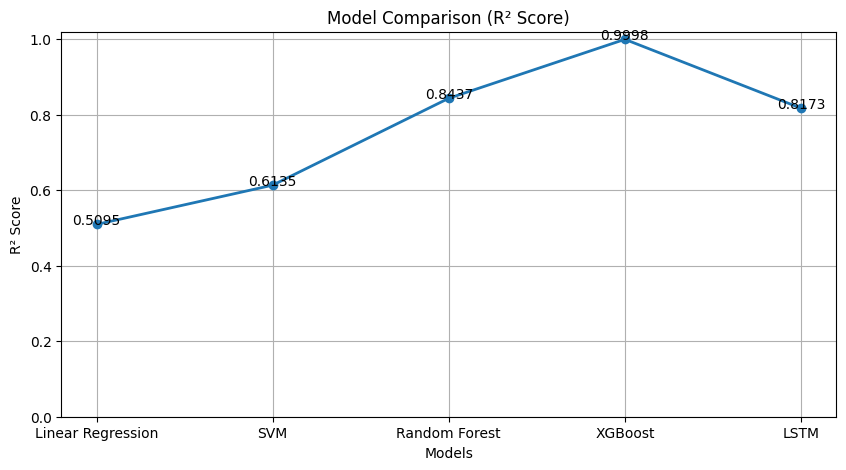

In [ ]:
import matplotlib.pyplot as plt

models = ['Linear Regression', 'SVM', 'Random Forest', 'XGBoost', 'LSTM']
scores = [r2_lr, r2_svm, r2_rf, r2_xgb, r2_lstm]

plt.figure(figsize=(10,5))

plt.plot(models, scores, marker='o', linewidth=2)

plt.title("Model Comparison (R² Score)")
plt.xlabel("Models")
plt.ylabel("R² Score")

plt.ylim(0, 1.02)   # IMPORTANT
plt.grid(True)

# show values
for i, v in enumerate(scores):
    plt.text(i, v+0.0001, f"{v:.4f}", ha='center')

plt.show()

In [ ]:
import numpy as np

y_test_np = y_test.values
y_pred_np = y_pred_xgb

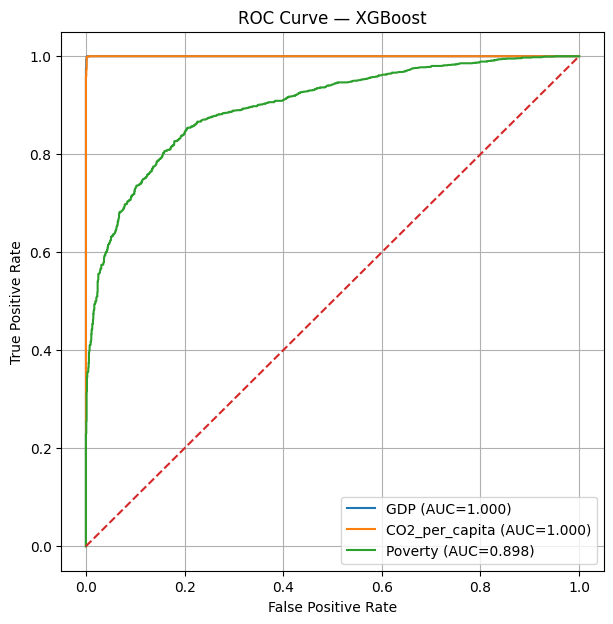

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

targets = ['GDP', 'CO2_per_capita', 'Poverty']

plt.figure(figsize=(7,7))

for i, target in enumerate(targets):

    # Convert regression → binary (for ROC only)
    y_test_binary = (y_test_np[:, i] > np.median(y_test_np[:, i])).astype(int)
    y_score = y_pred_np[:, i]

    fpr, tpr, _ = roc_curve(y_test_binary, y_score)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{target} (AUC={roc_auc:.3f})")

plt.plot([0,1],[0,1],'--')
plt.title("ROC Curve — XGBoost")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
df.to_csv("clean_merged_data.csv", index=False)

In [ ]:
from google.colab import files
files.download("clean_merged_data.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>